# Face mask detection with Keras, TensorFlow, and Deep Learning
## Yordan Penev

# Abstract

Our goal is to train an object detector capable of accurately predicting the bounding box coordinates and classify properly waring of face mask.


#### Our training script begins with our imports, the most notable being:

- VGG16: The CNN architecture to serve as the base network which we’ll modify for multi-class bounding box regression and then fine-tune on our dataset
- tf.keras: Imports from TensorFlow/Keras consisting of layer types, optimizers, and image loading/preprocessing routines  
- LabelBinarizer: One-hot encoding implemented in scikit-learn
- train_test_split: Scikit-learn’s convenience utility for partitioning our dataset into training and testing subsets
- matplotlib: Python’s de facto plotting package
- numpy: Python’s standard numerical processing library
- cv2: The OpenCV library


In [14]:
# import the necessary packages
import os
from os import listdir
from os.path import isfile, join
import xml.etree.ElementTree as ET
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

# Data

Our [dataset](https://www.kaggle.com/andrewmvd/face-mask-detection) contains two folders, one having images and other having annotations.Since each of these images contain multiple persons which are either wearing a mask or not weraing it or not wearing it properly, first we need to get these faces out of the images.



In [15]:
# define the base path to the *original* input dataset and then use
# the base path to derive the image and annotations directories
ORIG_BASE_PATH = "data"
ORIG_IMAGES = os.path.sep.join([ORIG_BASE_PATH, "images"])
ORIG_ANNOTS = os.path.sep.join([ORIG_BASE_PATH, "annotations"])

# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

#### Parsing data:

In [16]:
# define function to read and parse XML data
def read_content(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []

    for boxes in root.iter('object'):
        # find bounding box
        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        # find label
        label = boxes.find("name").text
        # stick data
        list_with_single_boxes = [xmin, ymin, xmax, ymax, label]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_boxes

In [17]:
datafiles = [f for f in listdir(ORIG_BASE_PATH) if isfile(join(ORIG_BASE_PATH, f))]

We initialize four empty lists associated with our data; these lists will soon be populated to include:

- data: Images
- labels: Class labels
- bboxes: Target bounding box (x, y)-coordinates
- imagePaths: The filepath of our images residing on disk

In [18]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

for i in range(0, len(datafiles), 2):
    #print('Image: ', datafiles[i])
    #print('Annotation: ', datafiles[i+1])
    imagePath = join(ORIG_BASE_PATH,datafiles[i])
    annotationPath = join(ORIG_BASE_PATH,datafiles[i+1])
    annotationContect = read_content(annotationPath)
    
    for o in range(len(annotationContect)):
        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        image = cv2.imread(imagePath)
        (h, w) = image.shape[:2]
        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(annotationContect[o][0]) / w
        startY = float(annotationContect[o][1]) / h
        endX = float(annotationContect[o][2]) / w
        endY = float(annotationContect[o][3]) / h

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(annotationContect[o][4])
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)
        
print("[INFO] loading dataset END")

[INFO] loading dataset...
[INFO] loading dataset END


We loaded the image from disk in Keras/TensorFlow format and preprocess it. Resizing step forces our image to 224×224 pixels for our VGG16-based CNN.

To close out our data preparation loop, we update each of our lists — data, labels, bboxes, and imagePaths, respectively.

Despite our data prep loop being finished, we still have a few more preprocessing tasks to take care of:

Now we have to:

- Convert each of our data lists to NumPy arrays
- One-hot encode our labels, making an exception for two-class data, which requires using the Keras/TensorFlow to_categorical function.


In [19]:
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
    labels = to_categorical(labels)

Using scikit-learn’s utility, we partition our data into 80% for training and 20% for testing.

We’ll be using our testing image paths in our prediction script for evaluation purposes, so now we have to export them to disk in a text file.

In [20]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
    test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()
print("[INFO] saving testing image paths END")

[INFO] saving testing image paths...
[INFO] saving testing image paths END


## Creating a model

We load the VGG16 network with weights pre-trained on the ImageNet dataset. We leave off the fully-connected layer head (include_top=False), since we will be constructing a new layer head responsible for multi-output prediction (i.e., class label and bounding box location).

We then flatten the output of the network so we can construct our new layer had and add it to the body of the network

In [21]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

The first branch, bboxHead, is responsible for predicting the bounding box (x, y)-coordinates of the object in the image. This branch is a simple fully-connected subnetwork, consisting of 128, 64, 32, and 4 nodes, respectively.

The most important part of our bounding box regression head is the final layer:

The 4 neurons corresponding to the (x, y)-coordinates for the top-left and top-right of the predicted bounding box.
We then use a sigmoid function to ensure our output predicted values are in the range [0, 1] (since we scaled our target/ground-truth bounding box coordinates to this range during the data preprocessing step).
Our second branch, softmaxHead, is responsible for predicting the class label of the detected object. If you’ve ever trained/fine-tuned a model for image classification, then this layer set should look quite familiar to you.

With our two layer heads constructed, we create a Model by using the frozen VGG16 weights as the body and the two new branches as the output layer head.

In [22]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
    name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
    name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

A visualization of the new two branch layer head can be seen below:

<br><br>

<img src="info/multi_class_bbox_regression_arch.png" alt="drawing"/>

<br><br>

The layer head is attached to the body of VGG16 and then splits into a branch for the class label prediction (left) along with the bounding box (x, y)-coordinate predictions (right).



The next step is to define our losses and compile the model. 

In [23]:
# deep learning hyperparameters
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 32

In [24]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

We then define a lossWeights dictionary which tells Keras/TensorFlow how to weight each of the branches during training. We want to weight both of the branches equally, so we set the weight values to 1.0 for each.

In [25]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

With the optimizer initialized, we compile the model and display a summary of the model architecture to our terminal

In [26]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/20
14/14 [==============================] - 67s 5s/step - loss: 2.2011 - bounding_box_loss: 0.0470 - class_label_loss: 2.1541 - bounding_box_accuracy: 0.4068 - class_label_accuracy: 0.1778 - val_loss: 1.8491 - val_bounding_box_loss: 0.0304 - val_class_label_loss: 1.8188 - val_bounding_box_accuracy: 0.6509 - val_class_label_accuracy: 0.1415
Epoch 2/20
14/14 [==============================] - 66s 5s/step - loss: 1.9646 - bounding_box_loss: 0.0317 - class_label_loss: 1.9329 - bounding_box_accuracy: 0.6412 - class_label_accuracy: 0.2288 - val_loss: 1.7753 - val_bounding_box_loss: 0.0294 - val_class_label_loss: 1.7459 - val_bounding_box_accuracy: 0.6604 - val_class_label_accuracy: 0.2736
Epoch 3/20
14/14 [==============================] - 64s 5s/step - loss: 1.8523 - bounding_box_loss: 0.0274 - class_label_loss: 1.8249 - bounding_box_accuracy: 0.7207 - class_label_accuracy: 0.2379 - val_loss: 1.7841 - val_bounding_box_loss: 0.0305 - val_class_label_loss: 1.7

## Visualising results

We visualize our total loss, class label loss (categorical cross-entropy), and bounding box regression loss (mean squared error).

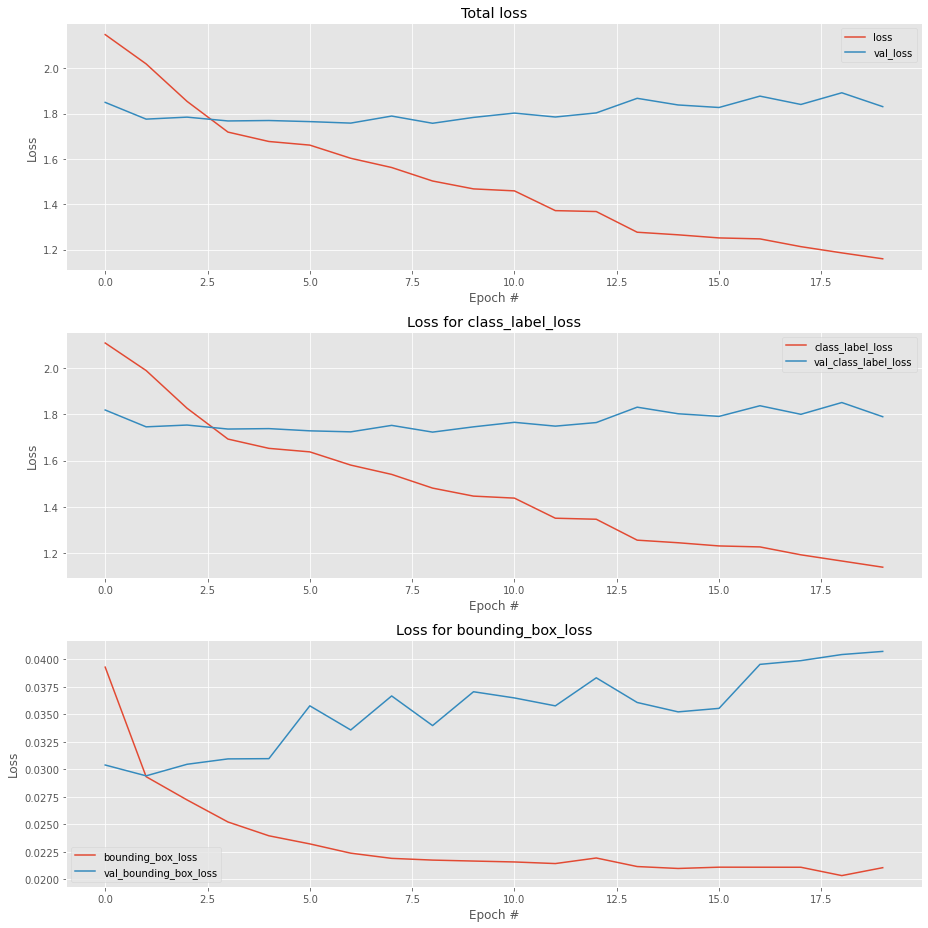

In [27]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.show()
plt.close()

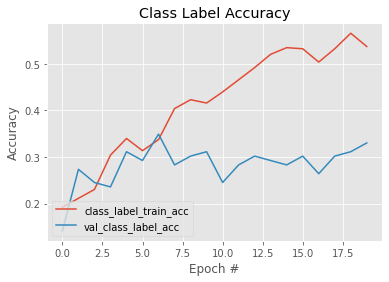

In [28]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
    label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
    label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)
plt.show()
plt.close()